<a href="https://colab.research.google.com/github/Sciform/sciform-hwz-ai-in-controlling/blob/main/Predict_Next_Purchase_Day.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install chart_studio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 64 kB 2.3 MB/s 
  Created wheel for retrying: filename=retrying-1.3.3-py3-none-any.whl size=11447 sha256=9751744f79d53d69402a04069cf8b7f3197a22dd7d3daa197bda29ab1325bbd3
  Stored in directory: /root/.cache/pip/wheels/f9/8d/8d/f6af3f7f9eea3553bc2fe6d53e4b287dad18b06a861ac56ddf
Successfully built retrying


In [2]:
from datetime import datetime, timedelta,date
import pandas as pd
%matplotlib inline
from sklearn.metrics import classification_report,confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from __future__ import division
from sklearn.cluster import KMeans

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
import chart_studio.plotly as py
import plotly.offline as pyoff
import plotly.graph_objs as go

In [5]:
from sklearn.svm import SVC
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.model_selection import KFold, cross_val_score, train_test_split

In [6]:
# pyoff.init_notebook_mode()

In [7]:
from google.colab import files
retail_data_file = files.upload()

Saving OnlineRetail.csv to OnlineRetail.csv


In [45]:
# tx_data = pd.read_csv('data.csv')
import io
tx_data = pd.read_csv(io.BytesIO(retail_data_file['OnlineRetail.csv']), encoding = "ISO-8859-1")

In [46]:
tx_data.shape

(541909, 8)

In [47]:
tx_data.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,12/1/2010 8:26,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,12/1/2010 8:26,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,12/1/2010 8:28,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,12/1/2010 8:28,1.85,17850.0,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,12/1/2010 8:34,1.69,13047.0,United Kingdom


In [48]:
tx_data['InvoiceDate'] = pd.to_datetime(tx_data['InvoiceDate'])

In [49]:
tx_data['InvoiceDate'].describe()

count                  541909
unique                  23260
top       2011-10-31 14:41:00
freq                     1114
first     2010-12-01 08:26:00
last      2011-12-09 12:50:00
Name: InvoiceDate, dtype: object

In [50]:
tx_uk = tx_data.query("Country=='United Kingdom'").reset_index(drop=True)

# Split data

We use six months of behavioral data to predict customers’ first purchase date in the next three months. 
If there is no purchase, we will predict that too. Let’s assume our cut off date is Sep 9th 2011.

In [51]:
# 6 month behavioural data
tx_6m = tx_uk[(tx_uk.InvoiceDate < pd.to_datetime(date(2011,9,1))) & (tx_uk.InvoiceDate >= pd.to_datetime(date(2011,3,1)))].reset_index(drop=True)
# 3 month to predict next purchase
tx_next = tx_uk[(tx_uk.InvoiceDate >= pd.to_datetime(date(2011,9,1))) & (tx_uk.InvoiceDate < pd.to_datetime(date(2011,12,1)))].reset_index(drop=True)

In [52]:
tx_next['InvoiceDate'].describe()

count                  178694
unique                   6781
top       2011-10-31 14:41:00
freq                     1114
first     2011-09-01 08:25:00
last      2011-11-30 17:42:00
Name: InvoiceDate, dtype: object

In [53]:
# all customers in the first 6 month 
tx_user = pd.DataFrame(tx_6m['CustomerID'].unique())
tx_user.columns = ['CustomerID']
tx_user

,CustomerID
0,14620.0
1,14740.0
2,13880.0
3,16462.0
4,17068.0
...,...
2564,16083.0
2565,13726.0
2566,15690.0
2567,17777.0


# Compute label 

The label is the days between last purchase before cut off date and first purchase after that.

In [54]:
# get first purchase date in last 3 month
tx_next_first_purchase = tx_next.groupby('CustomerID').InvoiceDate.min().reset_index()

In [55]:
tx_next_first_purchase.columns = ['CustomerID','MinPurchaseDate']

In [56]:
tx_next_first_purchase.head()

,CustomerID,MinPurchaseDate
0,12747.0,2011-10-04 08:26:00
1,12748.0,2011-09-02 10:49:00
2,12749.0,2011-11-17 12:05:00
3,12820.0,2011-09-26 11:49:00
4,12822.0,2011-09-13 13:46:00


In [57]:
# get last purchase date in first 6 month

tx_last_purchase = tx_6m.groupby('CustomerID').InvoiceDate.max().reset_index()

In [58]:
tx_last_purchase.columns = ['CustomerID','MaxPurchaseDate']

In [59]:
tx_purchase_dates = pd.merge(tx_last_purchase,tx_next_first_purchase,on='CustomerID',how='left')

In [60]:
# difference between last purchase day in first 6 month period and first purchase date in 3 month period in days

tx_purchase_dates['NextPurchaseDay'] = (tx_purchase_dates['MinPurchaseDate'] - tx_purchase_dates['MaxPurchaseDate']).dt.days

In [61]:
tx_purchase_dates.head()

,CustomerID,MaxPurchaseDate,MinPurchaseDate,NextPurchaseDay
0,12747.0,2011-08-22 10:38:00,2011-10-04 08:26:00,42.0
1,12748.0,2011-08-30 12:00:00,2011-09-02 10:49:00,2.0
2,12749.0,2011-08-18 06:19:00,2011-11-17 12:05:00,91.0
3,12821.0,2011-05-09 15:51:00,NaT,NaN
4,12823.0,2011-08-04 17:45:00,2011-09-26 07:35:00,52.0


In [62]:
tx_user = pd.merge(tx_user, tx_purchase_dates[['CustomerID','NextPurchaseDay']],on='CustomerID',how='left')

In [63]:
# tx_user holds for every customer ID the next purchase day time difference
tx_user.head()

,CustomerID,NextPurchaseDay
0,14620.0,NaN
1,14740.0,NaN
2,13880.0,57.0
3,16462.0,111.0
4,17068.0,16.0


In [64]:
tx_user.shape

(2569, 2)

In [65]:
# customers which are not appearing have not bought anything within the last 3 
# month and get a very long number of days (i.e. they will be identified 
# as not buying anything within the next 3 month.)
tx_user = tx_user.fillna(1008)

# Feature Engineering

For this project, we have selected our feature candidates like below:

*   RFM scores & clusters
*   Days between the last three purchases
*   Mean & standard deviation of the difference between purchases in days

## Recency on behavioural data of the last 6 month

In [66]:
tx_max_purchase = tx_6m.groupby('CustomerID').InvoiceDate.max().reset_index()

In [67]:
tx_max_purchase.columns = ['CustomerID','MaxPurchaseDate']

In [68]:
tx_max_purchase['Recency'] = (tx_max_purchase['MaxPurchaseDate'].max() - tx_max_purchase['MaxPurchaseDate']).dt.days

In [69]:
tx_user = pd.merge(tx_user, tx_max_purchase[['CustomerID','Recency']], on='CustomerID')

In [70]:
tx_user.head()

,CustomerID,NextPurchaseDay,Recency
0,14620.0,1008.0,104
1,14740.0,1008.0,91
2,13880.0,57.0,45
3,16462.0,111.0,85
4,17068.0,16.0,10


In [71]:
tx_user.Recency.describe()

count    2568.000000
mean       66.724299
std        52.251492
min         0.000000
25%        20.750000
50%        55.000000
75%       104.000000
max       183.000000
Name: Recency, dtype: float64

In [72]:
plot_data = [
    go.Histogram(
        x=tx_user['Recency']
    )
]

plot_layout = go.Layout(
        title='Recency'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

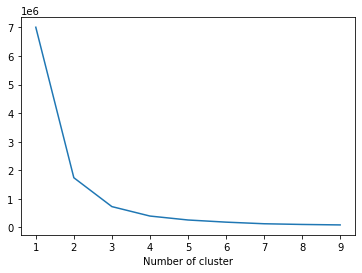

In [73]:
sse={}
tx_recency = tx_user[['Recency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(tx_recency)
    tx_recency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [74]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(tx_user[['Recency']])
tx_user['RecencyCluster'] = kmeans.predict(tx_user[['Recency']])

In [75]:
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final


In [76]:
tx_user = order_cluster('RecencyCluster', 'Recency',tx_user,False)

In [77]:
tx_user.groupby('RecencyCluster')['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,449.0,154.665924,15.863669,126.0,141.0,154.0,167.0,183.0
1,573.0,97.125654,13.976688,75.0,85.0,98.0,110.0,125.0
2,665.0,50.935338,12.413812,33.0,40.0,49.0,62.0,73.0
3,881.0,14.049943,8.883066,0.0,7.0,13.0,21.0,31.0


## Frequency for behavioural data of last 6 month

In [78]:
tx_frequency = tx_6m.groupby('CustomerID').InvoiceDate.count().reset_index()

In [79]:
tx_frequency.columns = ['CustomerID','Frequency']

In [80]:
tx_frequency.head()

,CustomerID,Frequency
0,12747.0,50
1,12748.0,1210
2,12749.0,160
3,12821.0,6
4,12823.0,2


In [81]:
tx_user = pd.merge(tx_user, tx_frequency, on='CustomerID')

In [82]:
tx_user.head()

,CustomerID,NextPurchaseDay,Recency,RecencyCluster,Frequency
0,14620.0,1008.0,104,1,30
1,14740.0,1008.0,91,1,93
2,16462.0,111.0,85,1,2
3,15676.0,178.0,113,1,63
4,15092.0,1008.0,115,1,26


In [83]:
tx_user.Frequency.describe()

count    2568.000000
mean       55.985981
std       109.245890
min         1.000000
25%        13.000000
50%        29.000000
75%        64.000000
max      3546.000000
Name: Frequency, dtype: float64

In [84]:
plot_data = [
    go.Histogram(
        x=tx_user.query('Frequency < 1000')['Frequency']
    )
]

plot_layout = go.Layout(
        title='Frequency'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

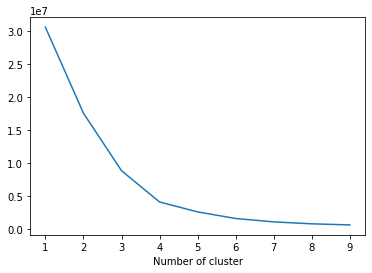

In [85]:
sse={}
tx_frequency = tx_user[['Frequency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(tx_frequency)
    tx_frequency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [86]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(tx_user[['Frequency']])
tx_user['FrequencyCluster'] = kmeans.predict(tx_user[['Frequency']])

In [87]:
tx_user.groupby('FrequencyCluster')['Frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,2239.0,31.732023,26.036899,1.0,11.00,23.0,46.00,107.0
1,1.0,3546.000000,NaN,3546.0,3546.00,3546.0,3546.00,3546.0
2,312.0,182.439103,70.488211,108.0,130.00,160.0,212.25,450.0
3,16.0,766.062500,260.797103,510.0,555.75,646.5,936.50,1251.0


In [88]:
tx_user = order_cluster('FrequencyCluster', 'Frequency',tx_user,True)

## Monetary Value of behavioural data of last 6 month

In [89]:
tx_6m['Revenue'] = tx_6m['UnitPrice'] * tx_6m['Quantity']

In [90]:
tx_revenue = tx_6m.groupby('CustomerID').Revenue.sum().reset_index()

In [91]:
tx_revenue.head()

,CustomerID,Revenue
0,12747.0,1760.09
1,12748.0,8115.68
2,12749.0,2532.55
3,12821.0,92.72
4,12823.0,688.50


In [92]:
tx_user = pd.merge(tx_user, tx_revenue, on='CustomerID')

In [93]:
tx_user.Revenue.describe()

count     2568.000000
mean      1078.621843
std       3156.461431
min      -4287.630000
25%        222.967500
50%        440.130000
75%       1026.340000
max      88948.330000
Name: Revenue, dtype: float64

In [94]:
plot_data = [
    go.Histogram(
        x=tx_user.query('Revenue < 10000')['Revenue']
    )
]

plot_layout = go.Layout(
        title='Monetary Value'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

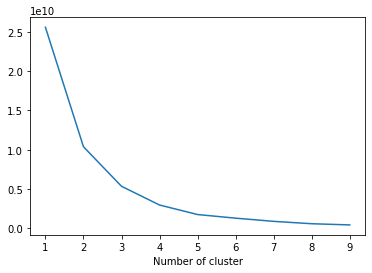

In [95]:
sse={}
tx_revenue = tx_user[['Revenue']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(tx_revenue)
    tx_revenue["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [96]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(tx_user[['Revenue']])
tx_user['RevenueCluster'] = kmeans.predict(tx_user[['Revenue']])

In [97]:
tx_user = order_cluster('RevenueCluster', 'Revenue',tx_user,True)

In [98]:
tx_user.groupby('RevenueCluster')['Revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
RevenueCluster,,,,,,,,
0,2415.0,635.360862,618.311128,-4287.63,212.1850,406.480,866.6600,2906.31
1,136.0,5237.716699,2617.500448,2952.40,3282.0950,4419.950,5634.9350,13760.87
2,15.0,24656.247333,7716.951663,15847.56,17484.2400,23196.350,31386.6450,37934.22
3,2.0,76665.615000,17370.382136,64382.90,70524.2575,76665.615,82806.9725,88948.33


## Overall Segmentation of behavioural data of past 6 month

In [99]:
tx_user.head()

,CustomerID,NextPurchaseDay,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster
0,14620.0,1008.0,104,1,30,0,393.28,0
1,14740.0,1008.0,91,1,93,0,1423.21,0
2,16462.0,111.0,85,1,2,0,68.00,0
3,15676.0,178.0,113,1,63,0,877.40,0
4,15092.0,1008.0,115,1,26,0,457.81,0


In [100]:
tx_user['OverallScore'] = tx_user['RecencyCluster'] + tx_user['FrequencyCluster'] + tx_user['RevenueCluster']

In [101]:
tx_user.groupby('OverallScore')['Recency','Frequency','Revenue'].mean()

,Recency,Frequency,Revenue
OverallScore,,,
0,154.750000,19.412162,289.172973
1,97.965766,27.293694,445.157207
2,52.656766,37.529703,576.943186
3,18.450808,52.588840,904.059517
4,15.445652,160.429348,2526.410000
5,9.815789,214.855263,6653.958947
6,8.812500,568.562500,13181.453125
7,12.200000,591.600000,46209.390000
8,3.000000,3546.000000,16643.220000


In [102]:
tx_user.groupby('OverallScore')['Recency'].count()

OverallScore
0    444
1    555
2    606
3    681
4    184
5     76
6     16
7      5
8      1
Name: Recency, dtype: int64

In [103]:
tx_user['Segment'] = 'Low-Value'
tx_user.loc[tx_user['OverallScore']>2,'Segment'] = 'Mid-Value' 
tx_user.loc[tx_user['OverallScore']>4,'Segment'] = 'High-Value' 

In [104]:
tx_graph = tx_user.query("Revenue < 50000 and Frequency < 2000")

plot_data = [
    go.Scatter(
        x=tx_graph.query("Segment == 'Low-Value'")['Frequency'],
        y=tx_graph.query("Segment == 'Low-Value'")['Revenue'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        go.Scatter(
        x=tx_graph.query("Segment == 'Mid-Value'")['Frequency'],
        y=tx_graph.query("Segment == 'Mid-Value'")['Revenue'],
        mode='markers',
        name='Mid',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        go.Scatter(
        x=tx_graph.query("Segment == 'High-Value'")['Frequency'],
        y=tx_graph.query("Segment == 'High-Value'")['Revenue'],
        mode='markers',
        name='High',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
]

plot_layout = go.Layout(
        yaxis= {'title': "Revenue"},
        xaxis= {'title': "Frequency"},
        title='Segments'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [105]:
tx_graph = tx_user.query("Revenue < 50000 and Frequency < 2000")

plot_data = [
    go.Scatter(
        x=tx_graph.query("Segment == 'Low-Value'")['Recency'],
        y=tx_graph.query("Segment == 'Low-Value'")['Revenue'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        go.Scatter(
        x=tx_graph.query("Segment == 'Mid-Value'")['Recency'],
        y=tx_graph.query("Segment == 'Mid-Value'")['Revenue'],
        mode='markers',
        name='Mid',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        go.Scatter(
        x=tx_graph.query("Segment == 'High-Value'")['Recency'],
        y=tx_graph.query("Segment == 'High-Value'")['Revenue'],
        mode='markers',
        name='High',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
]

plot_layout = go.Layout(
        yaxis= {'title': "Revenue"},
        xaxis= {'title': "Recency"},
        title='Segments'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [106]:
tx_graph = tx_user.query("Revenue < 50000 and Frequency < 2000")

plot_data = [
    go.Scatter(
        x=tx_graph.query("Segment == 'Low-Value'")['Recency'],
        y=tx_graph.query("Segment == 'Low-Value'")['Frequency'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        go.Scatter(
        x=tx_graph.query("Segment == 'Mid-Value'")['Recency'],
        y=tx_graph.query("Segment == 'Mid-Value'")['Frequency'],
        mode='markers',
        name='Mid',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        go.Scatter(
        x=tx_graph.query("Segment == 'High-Value'")['Recency'],
        y=tx_graph.query("Segment == 'High-Value'")['Frequency'],
        mode='markers',
        name='High',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
]

plot_layout = go.Layout(
        yaxis= {'title': "Frequency"},
        xaxis= {'title': "Recency"},
        title='Segments'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [107]:
tx_user.head()

,CustomerID,NextPurchaseDay,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment
0,14620.0,1008.0,104,1,30,0,393.28,0,1,Low-Value
1,14740.0,1008.0,91,1,93,0,1423.21,0,1,Low-Value
2,16462.0,111.0,85,1,2,0,68.00,0,1,Low-Value
3,15676.0,178.0,113,1,63,0,877.40,0,1,Low-Value
4,15092.0,1008.0,115,1,26,0,457.81,0,1,Low-Value


## Feature engineering for two new features

*  Days between the last three purchases
*  Mean & standard deviation of the difference between purchases in days

In [ ]:
tx_6m.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue
0,545220,21955,DOORMAT UNION JACK GUNS AND ROSES,2,2011-03-01 08:30:00,7.95,14620.0,United Kingdom,15.90
1,545220,48194,DOORMAT HEARTS,2,2011-03-01 08:30:00,7.95,14620.0,United Kingdom,15.90
2,545220,22556,PLASTERS IN TIN CIRCUS PARADE,12,2011-03-01 08:30:00,1.65,14620.0,United Kingdom,19.80
3,545220,22139,RETROSPOT TEA SET CERAMIC 11 PC,3,2011-03-01 08:30:00,4.95,14620.0,United Kingdom,14.85
4,545220,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,4,2011-03-01 08:30:00,3.75,14620.0,United Kingdom,15.00


In [119]:
#create a dataframe with CustomerID and Invoice Date
tx_day_order = tx_6m[['CustomerID','InvoiceDate']]

In [120]:
# Convert Invoice Datetime to day
tx_day_order['InvoiceDay'] = tx_6m['InvoiceDate'].dt.date

In [121]:
tx_day_order = tx_day_order.sort_values(['CustomerID','InvoiceDate'])
tx_day_order

,CustomerID,InvoiceDate,InvoiceDay
649,12747.0,2011-03-01 14:53:00,2011-03-01
650,12747.0,2011-03-01 14:53:00,2011-03-01
651,12747.0,2011-03-01 14:53:00,2011-03-01
652,12747.0,2011-03-01 14:53:00,2011-03-01
653,12747.0,2011-03-01 14:53:00,2011-03-01
...,...,...,...
195453,NaN,2011-08-31 17:18:00,2011-08-31
195454,NaN,2011-08-31 17:18:00,2011-08-31
195455,NaN,2011-08-31 17:21:00,2011-08-31
195456,NaN,2011-08-31 17:22:00,2011-08-31


In [122]:
# drop duplicates
tx_day_order = tx_day_order.drop_duplicates(subset=['CustomerID','InvoiceDay'],keep='first')

In [123]:
# shifting last 3 purchase dates
tx_day_order['L1InvoiceDate'] = tx_day_order.groupby('CustomerID')['InvoiceDay'].shift(1)
tx_day_order['L2InvoiceDate'] = tx_day_order.groupby('CustomerID')['InvoiceDay'].shift(2)
tx_day_order['L3InvoiceDate'] = tx_day_order.groupby('CustomerID')['InvoiceDay'].shift(3)

In [124]:
tx_day_order.head()

,CustomerID,InvoiceDate,InvoiceDay,L1InvoiceDate,L2InvoiceDate,L3InvoiceDate
649,12747.0,2011-03-01 14:53:00,2011-03-01,NaN,NaN,NaN
65091,12747.0,2011-05-05 15:31:00,2011-05-05,2011-03-01,NaN,NaN
90473,12747.0,2011-05-25 09:57:00,2011-05-25,2011-05-05,2011-03-01,NaN
124699,12747.0,2011-06-28 10:06:00,2011-06-28,2011-05-25,2011-05-05,2011-03-01
184410,12747.0,2011-08-22 10:38:00,2011-08-22,2011-06-28,2011-05-25,2011-05-05


In [125]:
tx_day_order['DayDiff1'] = (tx_day_order['InvoiceDay'] - tx_day_order['L1InvoiceDate']).dt.days
tx_day_order['DayDiff2'] = (tx_day_order['InvoiceDay'] - tx_day_order['L2InvoiceDate']).dt.days
tx_day_order['DayDiff3'] = (tx_day_order['InvoiceDay'] - tx_day_order['L3InvoiceDate']).dt.days

In [126]:
tx_day_order.head(10)

,CustomerID,InvoiceDate,InvoiceDay,L1InvoiceDate,L2InvoiceDate,L3InvoiceDate,DayDiff1,DayDiff2,DayDiff3
649,12747.0,2011-03-01 14:53:00,2011-03-01,NaN,NaN,NaN,NaN,NaN,NaN
65091,12747.0,2011-05-05 15:31:00,2011-05-05,2011-03-01,NaN,NaN,65.0,NaN,NaN
90473,12747.0,2011-05-25 09:57:00,2011-05-25,2011-05-05,2011-03-01,NaN,20.0,85.0,NaN
124699,12747.0,2011-06-28 10:06:00,2011-06-28,2011-05-25,2011-05-05,2011-03-01,34.0,54.0,119.0
184410,12747.0,2011-08-22 10:38:00,2011-08-22,2011-06-28,2011-05-25,2011-05-05,55.0,89.0,109.0
7326,12748.0,2011-03-08 12:30:00,2011-03-08,NaN,NaN,NaN,NaN,NaN,NaN
10606,12748.0,2011-03-11 11:37:00,2011-03-11,2011-03-08,NaN,NaN,3.0,NaN,NaN
17545,12748.0,2011-03-18 13:08:00,2011-03-18,2011-03-11,2011-03-08,NaN,7.0,10.0,NaN
20123,12748.0,2011-03-21 15:40:00,2011-03-21,2011-03-18,2011-03-11,2011-03-08,3.0,10.0,13.0
24764,12748.0,2011-03-24 13:37:00,2011-03-24,2011-03-21,2011-03-18,2011-03-11,3.0,6.0,13.0


In [129]:
tx_day_diff = tx_day_order.groupby('CustomerID').agg({'DayDiff1': ['mean','std']}).reset_index()

In [136]:
tx_day_diff.columns = ['CustomerID', 'DayDiff1Mean','DayDiff1Std']

In [137]:
tx_day_diff.head()

,CustomerID,DayDiff1Mean,DayDiff1Std
0,12747.0,43.500000,20.305993
1,12748.0,3.723404,3.083632
2,12749.0,25.000000,30.099834
3,12821.0,NaN,NaN
4,12823.0,127.000000,NaN


In [138]:
# We only keep customers who have > 3 purchases by using the following line

tx_day_order_last = tx_day_order.drop_duplicates(subset=['CustomerID'], keep='last')

In [139]:
tx_day_order_last.head(10)

,CustomerID,InvoiceDate,InvoiceDay,L1InvoiceDate,L2InvoiceDate,L3InvoiceDate,DayDiff1,DayDiff2,DayDiff3
184410,12747.0,2011-08-22 10:38:00,2011-08-22,2011-06-28,2011-05-25,2011-05-05,55.0,89.0,109.0
192527,12748.0,2011-08-30 12:00:00,2011-08-30,2011-08-25,2011-08-24,2011-08-17,5.0,6.0,13.0
181411,12749.0,2011-08-18 06:19:00,2011-08-18,2011-08-11,2011-08-01,2011-05-23,7.0,17.0,87.0
70339,12821.0,2011-05-09 15:51:00,2011-05-09,NaN,NaN,NaN,NaN,NaN,NaN
169417,12823.0,2011-08-04 17:45:00,2011-08-04,2011-03-30,NaN,NaN,127.0,NaN,NaN
122212,12826.0,2011-06-24 11:47:00,2011-06-24,2011-06-14,NaN,NaN,10.0,NaN,NaN
182629,12828.0,2011-08-19 09:23:00,2011-08-19,2011-08-01,NaN,NaN,18.0,NaN,NaN
162086,12830.0,2011-07-28 17:17:00,2011-07-28,2011-07-21,2011-07-06,2011-06-21,7.0,22.0,37.0
21424,12831.0,2011-03-22 13:02:00,2011-03-22,NaN,NaN,NaN,NaN,NaN,NaN
147556,12833.0,2011-07-17 13:46:00,2011-07-17,NaN,NaN,NaN,NaN,NaN,NaN


In [140]:
tx_day_order_last = tx_day_order_last.dropna()

In [141]:
tx_day_order_last = pd.merge(tx_day_order_last, tx_day_diff, on='CustomerID')

In [142]:
tx_user = pd.merge(tx_user, tx_day_order_last[['CustomerID','DayDiff1','DayDiff2','DayDiff3','DayDiff1Mean','DayDiff1Std']], on='CustomerID')

In [143]:
tx_user.head()

,CustomerID,NextPurchaseDay,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment,DayDiff1,DayDiff2,DayDiff3,DayDiff1Mean,DayDiff1Std
0,14740.0,1008.0,91,1,93,0,1423.21,0,1,Low-Value,6.0,34.0,92.0,30.666667,26.102363
1,17770.0,1008.0,98,1,38,0,1143.27,0,1,Low-Value,14.0,77.0,84.0,28.000000,30.512293
2,15643.0,1008.0,79,1,36,0,647.40,0,1,Low-Value,5.0,6.0,12.0,25.750000,43.553607
3,14231.0,1008.0,79,1,35,0,513.11,0,1,Low-Value,4.0,53.0,103.0,34.333333,26.274195
4,18218.0,1008.0,106,1,24,0,626.38,0,1,Low-Value,5.0,61.0,75.0,25.000000,27.221315


In [144]:
len(tx_user)

623

# Classification




## Feature engineering

Encode categorical data numerically.

In [162]:
tx_user_copy = tx_user.copy()

In [163]:
tx_enc_data = pd.get_dummies(tx_user_copy)

In [164]:
tx_enc_data.tail(10)

,CustomerID,NextPurchaseDay,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,DayDiff1,DayDiff2,DayDiff3,DayDiff1Mean,DayDiff1Std,Segment_High-Value,Segment_Low-Value,Segment_Mid-Value
613,16029.0,12.0,7,3,127,1,17081.82,2,6,6.0,7.0,19.0,7.318182,5.276961,1,0,0
614,17511.0,21.0,14,3,450,1,37661.72,2,6,9.0,13.0,28.0,9.625000,7.940403,1,0,0
615,14680.0,26.0,21,3,145,1,15847.56,2,6,14.0,33.0,57.0,19.142857,10.976165,1,0,0
616,14088.0,74.0,28,3,203,1,17886.66,2,6,7.0,15.0,21.0,12.400000,7.436397,1,0,0
617,15311.0,13.0,12,3,1061,2,31277.65,2,7,1.0,4.0,9.0,4.750000,3.417392,1,0,0
618,13089.0,0.0,0,3,895,2,22670.13,2,7,6.0,9.0,12.0,4.214286,3.008409,1,0,0
619,14298.0,23.0,23,3,750,2,23767.94,2,7,18.0,42.0,67.0,14.400000,10.297788,1,0,0
620,17841.0,3.0,3,3,3546,3,16643.22,2,8,3.0,5.0,9.0,3.423077,1.318736,1,0,0
621,18102.0,27.0,26,3,136,1,88948.33,3,7,8.0,16.0,32.0,12.916667,9.718383,1,0,0
622,17450.0,1.0,0,3,116,1,64382.90,3,7,8.0,14.0,34.0,11.666667,8.820971,1,0,0


## Choose classes based on quantiles of NextPurchaseDay difference


In [165]:
# characteristics of next purchase day

tx_user.NextPurchaseDay.describe()

count     623.000000
mean      177.603531
std       329.545266
min         0.000000
25%        24.500000
50%        47.000000
75%        87.000000
max      1008.000000
Name: NextPurchaseDay, dtype: float64

Create 3 classes with

*  0–20: Customers that will purchase in 0–20 days — Class name: 2
*  21–49: Customers that will purchase in 21–49 days — Class name: 1
*  ≥ 50: Customers that will purchase in more than 50 days — Class name: 0

In [166]:
tx_enc_data['NextPurchaseDayRange'] = 2
tx_enc_data.loc[tx_enc_data.NextPurchaseDay>20,'NextPurchaseDayRange'] = 1
tx_enc_data.loc[tx_enc_data.NextPurchaseDay>50,'NextPurchaseDayRange'] = 0


In [167]:
size_of_classes_in_pct = tx_enc_data.NextPurchaseDayRange.value_counts()/len(tx_user)

## Compute correlation between features and label

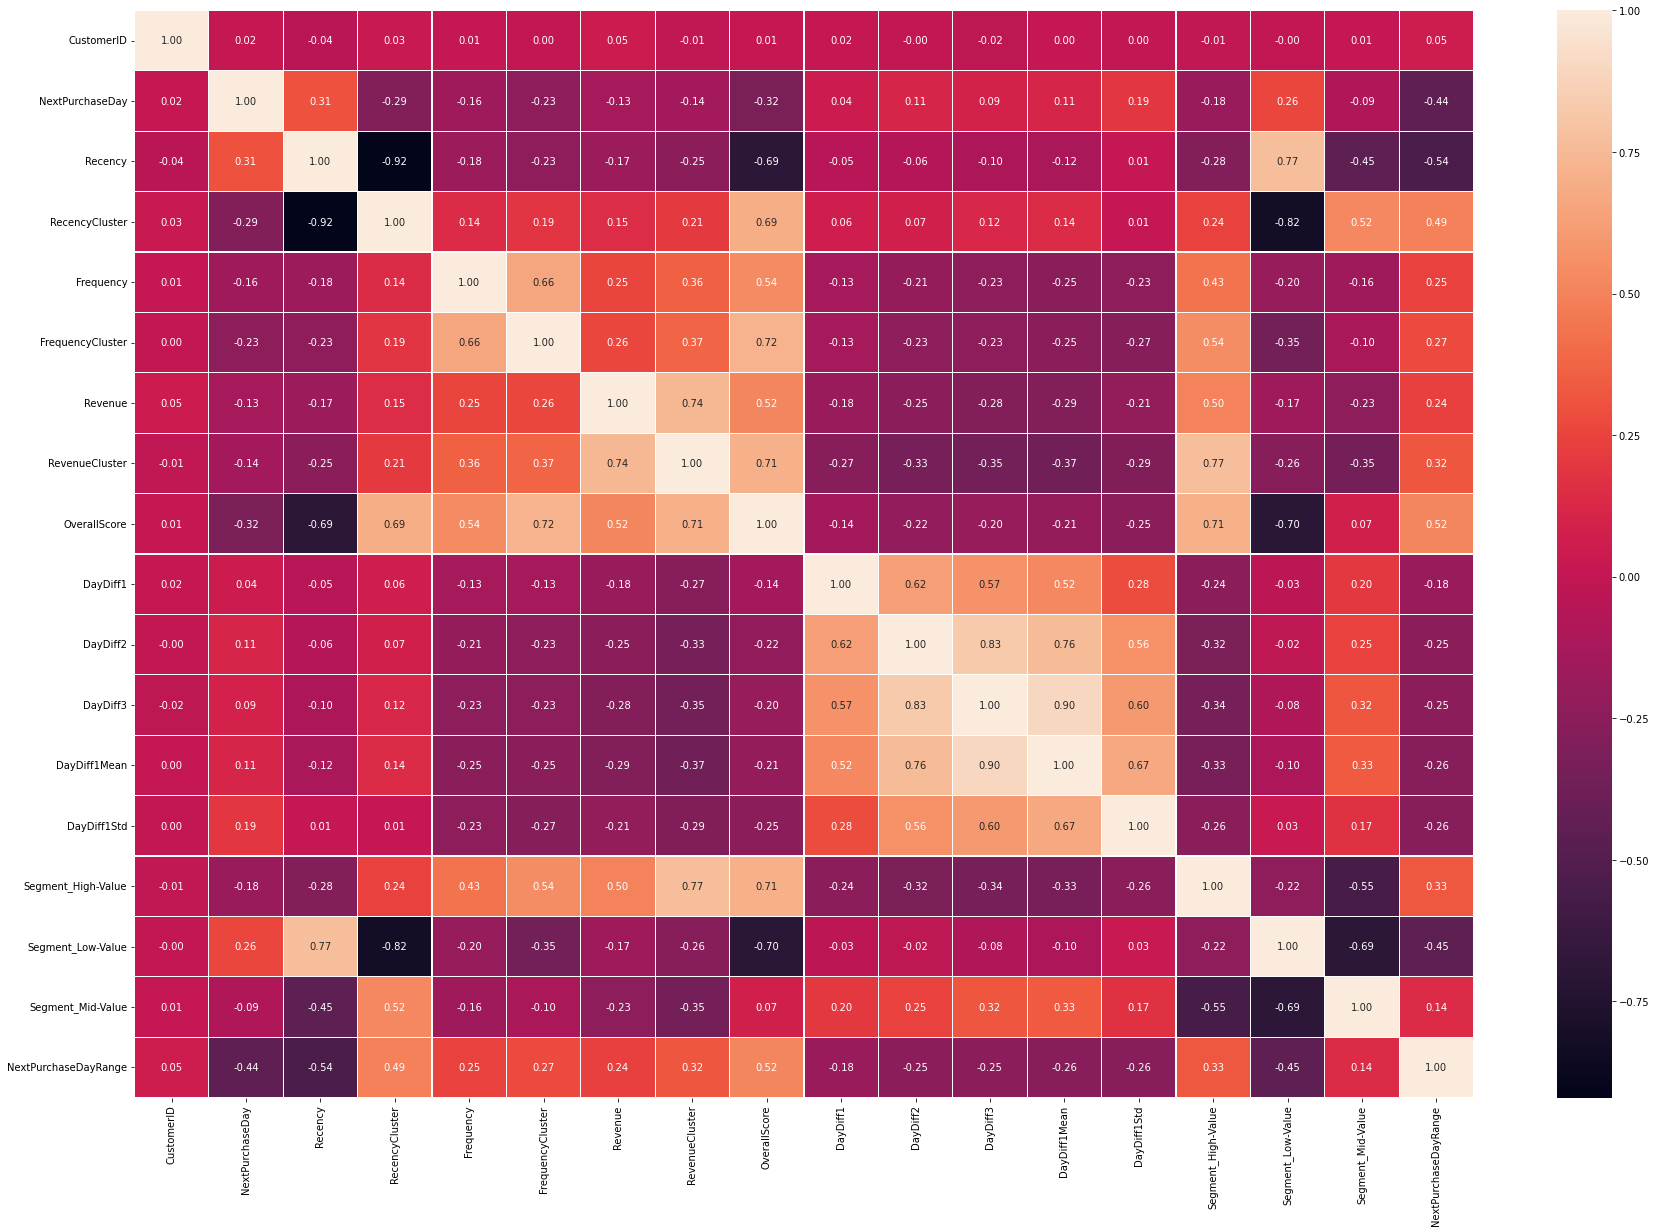

In [168]:
corr = tx_enc_data[tx_enc_data.columns].corr()
plt.figure(figsize = (30,20))
sns.heatmap(corr, annot = True, linewidths=0.2, fmt=".2f")

# Looks like Overall Score has the highest positive correlation (0.45) and Recency has the highest negative (-0.54).

## Create feature dataframe X and label dataframe y

In [169]:
# drop NextPurchaseDay first
tx_enc_data = tx_enc_data.drop('NextPurchaseDay', axis=1)

In [170]:
len(tx_enc_data)

623

In [172]:
X = tx_enc_data.drop('NextPurchaseDayRange', axis=1)
X

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,DayDiff1,DayDiff2,DayDiff3,DayDiff1Mean,DayDiff1Std,Segment_High-Value,Segment_Low-Value,Segment_Mid-Value
0,14740.0,91,1,93,0,1423.21,0,1,6.0,34.0,92.0,30.666667,26.102363,0,1,0
1,17770.0,98,1,38,0,1143.27,0,1,14.0,77.0,84.0,28.000000,30.512293,0,1,0
2,15643.0,79,1,36,0,647.40,0,1,5.0,6.0,12.0,25.750000,43.553607,0,1,0
3,14231.0,79,1,35,0,513.11,0,1,4.0,53.0,103.0,34.333333,26.274195,0,1,0
4,18218.0,106,1,24,0,626.38,0,1,5.0,61.0,75.0,25.000000,27.221315,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
618,13089.0,0,3,895,2,22670.13,2,7,6.0,9.0,12.0,4.214286,3.008409,1,0,0
619,14298.0,23,3,750,2,23767.94,2,7,18.0,42.0,67.0,14.400000,10.297788,1,0,0
620,17841.0,3,3,3546,3,16643.22,2,8,3.0,5.0,9.0,3.423077,1.318736,1,0,0
621,18102.0,26,3,136,1,88948.33,3,7,8.0,16.0,32.0,12.916667,9.718383,1,0,0


In [173]:
y = tx_enc_data.NextPurchaseDayRange
y

0      0
1      0
2      0
3      0
4      0
      ..
618    2
619    1
620    2
621    1
622    2
Name: NextPurchaseDayRange, Length: 623, dtype: int64

## Split feature data X and Label data y in training X_train, y_train and test data X_test, y_test.

In [178]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

## Train with various classificaton models and compare accuracy.

In [181]:
models = []
models.append(("LR",LogisticRegression()))
models.append(("NB",GaussianNB()))
models.append(("RF",RandomForestClassifier()))
models.append(("SVC",SVC()))
models.append(("Dtree", DecisionTreeClassifier()))
models.append(("XGB",xgb.XGBClassifier()))
models.append(("KNN",KNeighborsClassifier()))


In [192]:
for name,model in models:
    kfold = KFold(n_splits=3, shuffle=True)
    cv_result = cross_val_score(model, X_train, y_train, cv = kfold, scoring = "accuracy")
    print(name, cv_result)

LR [0.59036145 0.59638554 0.56626506]
NB [0.62048193 0.63253012 0.60240964]
RF [0.64457831 0.56024096 0.57831325]
SVC [0.46987952 0.52409639 0.43373494]
Dtree [0.60843373 0.59036145 0.55421687]
XGB [0.6626506  0.57831325 0.57831325]
KNN [0.46987952 0.39156627 0.48795181]


In [183]:
xgb_model = xgb.XGBClassifier().fit(X_train, y_train)

print('Accuracy of XGB classifier on training set: {:.2f}'
       .format(xgb_model.score(X_train, y_train)))
print('Accuracy of XGB classifier on test set: {:.2f}'
       .format(xgb_model.score(X_test[X_train.columns], y_test)))



Accuracy of XGB classifier on training set: 0.92
Accuracy of XGB classifier on test set: 0.58


In [184]:
y_pred = xgb_model.predict(X_test)

In [186]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.64      0.73        69
           1       0.35      0.53      0.42        34
           2       0.48      0.50      0.49        22

    accuracy                           0.58       125
   macro avg       0.56      0.56      0.55       125
weighted avg       0.66      0.58      0.61       125



# Hyperparameter tuning

In [188]:
from sklearn.model_selection import GridSearchCV

param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = xgb.XGBClassifier(), param_grid = param_test1, scoring='accuracy',n_jobs=-1, cv=2)
gsearch1.fit(X_train,y_train)
gsearch1.best_params_, gsearch1.best_score_

({'max_depth': 5, 'min_child_weight': 5}, 0.6044176706827309)

In [189]:
xgb_model = xgb.XGBClassifier(max_depth=5, min_child_weight=5).fit(X_train, y_train)

print('Accuracy of XGB classifier on training set: {:.2f}'
       .format(xgb_model.score(X_train, y_train)))
print('Accuracy of XGB classifier on test set: {:.2f}'
       .format(xgb_model.score(X_test[X_train.columns], y_test)))



Accuracy of XGB classifier on training set: 0.99
Accuracy of XGB classifier on test set: 0.60


In [190]:
y_pred = xgb_model.predict(X_test)

In [191]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.65      0.73        69
           1       0.37      0.50      0.42        34
           2       0.52      0.59      0.55        22

    accuracy                           0.60       125
   macro avg       0.57      0.58      0.57       125
weighted avg       0.65      0.60      0.62       125

